## Import TensorFlow and other libraries

In [1]:
import outils
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df = outils.Load_data.load_object("dataset2.zip")

In [3]:
df.reshape(target_shape=(64,64,3), batch_size = 32)

Reshape en batch: 100%|██████████| 380/380 [00:18<00:00, 20.73it/s]


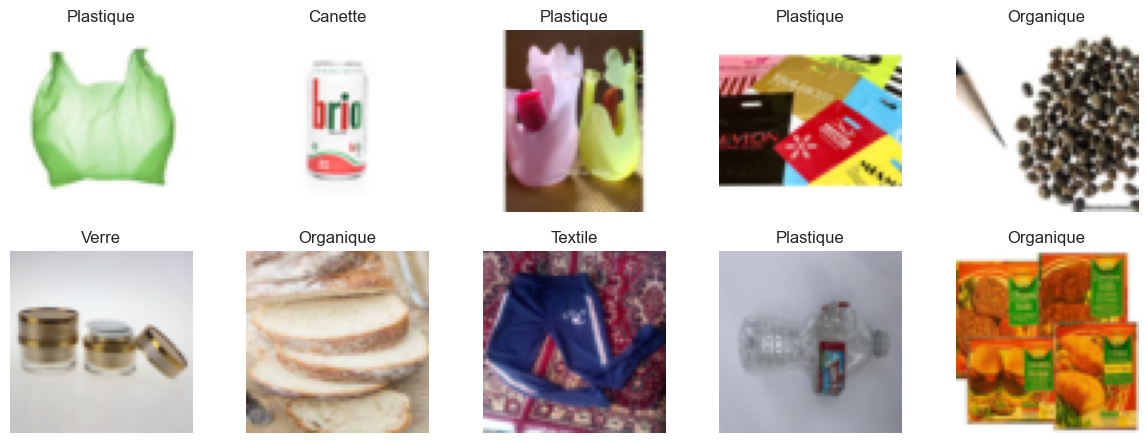

In [4]:
df.plot()

In [5]:
df.encodage()

In [6]:
(X_train, _), (X_test, _ ) = df.create_data(test_size=0.1)

In [7]:
print(f"X_train shape : {X_train.shape}")
print(f"X_test  shape : {X_test.shape}")

X_train shape : (10924, 64, 64, 3)
X_test  shape : (1214, 64, 64, 3)


In [8]:
X_vis = X_test[0:10]

In [9]:
X_vis = X_vis.astype("float32") / 255.

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=25,  
    width_shift_range=0.15,  
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2, 
    horizontal_flip=True,
    vertical_flip=False, 
    brightness_range=[0.8, 1.2], 
    fill_mode='nearest',
    rescale=1./255
)


test_datagen =  ImageDataGenerator(rescale= 1. / 255)

In [11]:
train_generator = train_datagen.flow(X_train,X_train,batch_size=64)
test_generator  = test_datagen.flow(X_test,X_test,batch_size=64)

In [ ]:
#noise_adder = outils.NoiseAdder(X_train)

In [ ]:
#noisy_gaussian = noise_adder.apply("gaussian", std=0.2)

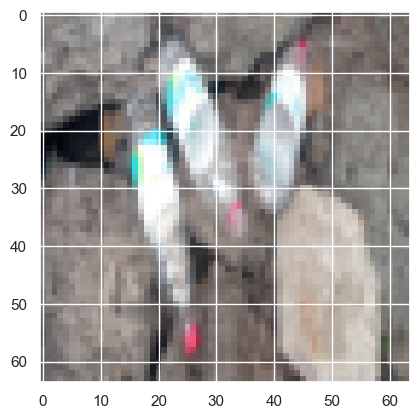

In [20]:
plt.imshow(X_test[8])

In [10]:
X_train = X_train.astype("float32") / 255.

In [11]:
X_test = X_test.astype("float32") / 255.

In [12]:
print(f"min = {np.min(X_test)} et max = {np.max(X_test)}")

min = 0.0 et max = 1.0


In [13]:
print(f"min = {np.min(X_train)} et max = {np.max(X_train)}")

min = 0.0 et max = 1.0


In [ ]:
plt.figure(figsize=(18,9))
for i in range(1,11):
    plt.subplot(4,5,i)
    plt.imshow(X_train[i])
    plt.title(y_train[i])
    plt.tight_layout()
plt.show()

In [12]:
import os 
import numpy as np
import json
import tensorflow as tf 
from tensorflow.keras import layers, models, losses, callbacks, regularizers
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau

In [13]:
from keras.saving import register_keras_serializable

In [ ]:
def ResidualBlock(filters, stride=1, use_bn=True, l2=1e-4):
    def f(x):
        shortcut = x
        y = layers.Conv2D(filters, 3, strides=stride, padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(l2), use_bias=not use_bn)(x)
        if use_bn: y = layers.BatchNormalization()(y)
        y = layers.Activation("relu")(y)

        y = layers.Conv2D(filters, 3, padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(l2), use_bias=not use_bn)(y)
        if use_bn: y = layers.BatchNormalization()(y)

        # Adapter raccourci
        if shortcut.shape[-1] != filters or stride != 1:
            shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same",
                                     kernel_regularizer=tf.keras.regularizers.l2(l2),
                                     use_bias=not use_bn)(shortcut)
            if use_bn: shortcut = layers.BatchNormalization()(shortcut)

        out = layers.Add()([y, shortcut])
        out = layers.Activation("relu")(out)
        return out
    return f


# -----------------------------
# Bloc résiduel upsampling
# -----------------------------
def ResidualBlockUp(filters, scale=2, use_bn=True, l2=1e-4):
    def f(x):
        shortcut = x
        y = layers.UpSampling2D(size=(scale, scale))(x)
        y = layers.Conv2D(filters, 3, padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(l2), use_bias=not use_bn)(y)
        if use_bn: y = layers.BatchNormalization()(y)
        y = layers.Activation("relu")(y)

        y = layers.Conv2D(filters, 3, padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(l2), use_bias=not use_bn)(y)
        if use_bn: y = layers.BatchNormalization()(y)

        shortcut = layers.UpSampling2D(size=(scale, scale))(shortcut)
        shortcut = layers.Conv2D(filters, 1, padding="same",
                                 kernel_regularizer=tf.keras.regularizers.l2(l2),
                                 use_bias=not use_bn)(shortcut)
        if use_bn: shortcut = layers.BatchNormalization()(shortcut)

        out = layers.Add()([y, shortcut])
        out = layers.Activation("relu")(out)
        return out
    return f


# -----------------------------
# Échantillonnage
# -----------------------------
@register_keras_serializable()
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_logvar = inputs
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_logvar) * eps


# -----------------------------
def build_encoder(input_shape=(240, 240, 3), latent_dim=128, base=32):
    inp = layers.Input(shape=input_shape)
    x = inp

    # downsampling avec blocs résiduels
    x = layers.Conv2D(base, 3, padding="same")(x)
    x = layers.Activation("relu")(x)

    x = ResidualBlock(base,   stride=1)(x)  # HxW
    x = ResidualBlock(base*2, stride=2)(x)  # H/2 x W/2
    x = ResidualBlock(base*2, stride=1)(x)
    x = ResidualBlock(base*4, stride=2)(x)  # H/4 x W/4
    x = ResidualBlock(base*4, stride=1)(x)
    x = ResidualBlock(base*8, stride=2)(x)  # H/8 x W/8
    x = ResidualBlock(base*8, stride=1)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(2*latent_dim, activation="relu")(x)

    z_mean   = layers.Dense(latent_dim, name="z_mean")(x)
    z_logvar = layers.Dense(latent_dim, name="z_logvar")(x)
    z = Sampling()([z_mean, z_logvar])

    return tf.keras.Model(inp, [z_mean, z_logvar, z], name="encoder")

def build_decoder(output_shape=(240, 240, 3), latent_dim=128, base=32):
    H, W, C = output_shape
    h0, w0 = H // 8, W // 8
    
    inp = layers.Input(shape=(latent_dim,))
    x = layers.Dense(h0 * w0 * base*8, activation="relu")(inp)
    x = layers.Reshape((h0, w0, base*8))(x)

    x = ResidualBlock(base*8, stride=1)(x)
    x = ResidualBlockUp(base*4)(x)
    x = ResidualBlock(base*4, stride=1)(x)
    x = ResidualBlockUp(base*2)(x)
    x = ResidualBlock(base*2, stride=1)(x)
    x = ResidualBlockUp(base)(x)
    x = ResidualBlock(base, stride=1)(x)

    # IMPORTANT: Pas d'activation sigmoid ici (on veut des logits)
    out = layers.Conv2D(C, 3, padding="same")(x)  # Pas d'activation !
    return tf.keras.Model(inp, out, name="decoder")


# -----------------------------
# Callback pour affichage reconstruction
# -----------------------------
class PlotReconstructionCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, x_vis):
        super().__init__()
        self.vae_model = model
        self.x_vis = x_vis.astype("float32")
        
        # Si les images sont en [0,255], normaliser
        if self.x_vis.max() > 1.0:
            self.x_vis = self.x_vis / 255.0

    def on_epoch_end(self, epoch, logs=None):
        # Inférence
        mean, logvar = self.vae_model.encode(self.x_vis)
        z = self.vae_model.reparameterize(mean, logvar)
        recon_logits = self.vae_model.decode(z)
        recon = tf.nn.sigmoid(recon_logits)  # Application de sigmoid pour visualisation
        
        n = min(5, len(self.x_vis))
        plt.figure(figsize=(20, 8))
        for i in range(n):
            # Original
            plt.subplot(2, n, i + 1)
            plt.imshow(np.clip(self.x_vis[i], 0, 1))
            plt.axis("off")
            plt.title("Original")

            # Reconstruit
            plt.subplot(2, n, n + i + 1)
            plt.imshow(np.clip(recon[i], 0, 1))
            plt.axis("off")
            plt.title(f"Reconstruit (KL: {logs.get('kl_loss', 0):.1f})")
        
        plt.suptitle(f"Époque {epoch + 1}")
        plt.tight_layout()
        plt.show()

class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, save_dir="training_checkpoint"):
        super().__init__()
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Mettre à jour l'historique
        for k, v in logs.items():
            self.history.setdefault(k, []).append(float(v))

        # Sauvegarde de l’historique JSON
        history_path = os.path.join(self.save_dir, "history.json")
        with open(history_path, "w") as f:
            json.dump(self.history, f)

        # Sauvegarde de l'époque actuelle
        epoch_path = os.path.join(self.save_dir, "epoch.txt")
        with open(epoch_path, "w") as f:
            f.write(str(epoch + 1))  # +1 car epoch commence à 0


@register_keras_serializable()
class ResidualVAE(tf.keras.Model):
    def __init__(
        self, 
        encoder, 
        decoder, 
        beta=0.001,
        add_noise=True,          # <-- activer/désactiver le bruit
        noise_std=0.2,           # <-- intensité du bruit gaussien
        dropout_rate=0.0,        # <-- dropout aléatoire optionnel
        **kwargs
    ):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

        self.add_noise = add_noise
        self.noise_std = noise_std
        self.dropout_rate = dropout_rate

        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

        self.log2pi = tf.math.log(2. * np.pi)


    # Pour la sérialisation Keras
    def get_config(self):
        config = super().get_config()
        config.update({
            "beta": self.beta,
            "add_noise": self.add_noise,
            "noise_std": self.noise_std,
            "dropout_rate": self.dropout_rate,
            "encoder": tf.keras.utils.serialize_keras_object(self.encoder),
            "decoder": tf.keras.utils.serialize_keras_object(self.decoder),
        })
        return config

    @classmethod
    def from_config(cls, config):
        encoder = tf.keras.utils.deserialize_keras_object(config.pop("encoder"))
        decoder = tf.keras.utils.deserialize_keras_object(config.pop("decoder"))
        return cls(encoder=encoder, decoder=decoder, **config)


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.recon_loss_tracker,
            self.kl_loss_tracker,
        ]

    
    def encode(self, x):
        z_mean, z_logvar, _ = self.encoder(x, training=True)
        return z_mean, z_logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * logvar) * eps
    
    def decode(self, z):
        return self.decoder(z, training=True)
    
    def log_normal_pdf(self, sample, mean, logvar, raxis=1):
        return tf.reduce_sum(
            -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + self.log2pi),
            axis=raxis
        )

    def compute_loss(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_logit = self.decode(z)  
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        logpz = self.log_normal_pdf(z, 0., 0.)  
        logqz_x = self.log_normal_pdf(z, mean, logvar)
        kl_loss = logqz_x - logpz
        total_loss = -tf.reduce_mean(logpx_z - self.beta * kl_loss)
        recon_loss = -tf.reduce_mean(logpx_z)
        mean_kl = tf.reduce_mean(kl_loss)
        
        return total_loss, recon_loss, mean_kl
    # ------------------------
    # Fonction pour ajouter du bruit
    # ------------------------
    def add_training_noise(self, x):
        if not self.add_noise:
            return x

        # Bruit gaussien
        x_noisy = x + tf.random.normal(
            shape=tf.shape(x),
            mean=0.0,
            stddev=self.noise_std
        )

        # Dropout (optionnel)
        if self.dropout_rate > 0.0:
            x_noisy = tf.nn.dropout(x_noisy, rate=self.dropout_rate)

        # Clamp entre 0–1
        x_noisy = tf.clip_by_value(x_noisy, 0.0, 1.0)

        return x_noisy


    # ------------------------
    # TRAIN STEP MODIFIÉ
    # ------------------------
    def train_step(self, data):
        if isinstance(data, (tuple, list)):
            x = data[0]
        else:
            x = data
        
        
        x_noisy = self.add_training_noise(x)
        
        with tf.GradientTape() as tape:
            total_loss, recon_loss, kl_loss = self.compute_loss(x_noisy)
        
        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

         # Mise à jour des métriques
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    # ------------------------
    # TEST STEP (sans bruit)
    # ------------------------
    def test_step(self, data):
        if isinstance(data, (tuple, list)):
            x = data[0]
        else:
            x = data
        
        # Pas d'augmentation ni de bruit en validation
        total_loss, recon_loss, kl_loss = self.compute_loss(x)
        
        return {
            "loss": total_loss,
            "recon_loss": recon_loss,
            "kl_loss": kl_loss,
        }

    def call(self, x):
        
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z)
    
    def train(
        self, x_train, x_val=None, batch_size=32, epochs=100, x_vis=None, save_path="residual_vae.keras",
         save_dir="training_checkpoint", initial_epoch=0,
    ):
        self.compile(optimizer=Adam(learning_rate=1e-3))

        callbacks_list = [
            SaveHistoryCallback(save_dir=save_dir),
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=80, restore_best_weights=True
            ),
            tf.keras.callbacks.ModelCheckpoint(save_path,monitor="val_recon_loss",verbose=1,save_best_only=True,mode="min"),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss", factor=0.5, patience=10, verbose=1, min_lr=1e-7
            ),
        ]

        if x_vis is not None:
            callbacks_list.append(PlotReconstructionCallback(self, x_vis))

        history = self.fit(
            x_train,
            validation_data=x_val if x_val is not None else None,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks_list,
            shuffle=True,
        )
        return history

In [15]:
input_shape = (64, 64, 3)   
latent_dim = 128

encoder = build_encoder(input_shape=input_shape, latent_dim=latent_dim, base=32)
decoder = build_decoder(output_shape=input_shape, latent_dim=latent_dim, base=32)

In [16]:
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      9,216 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     18,432 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,864 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │      2,048 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_5[0][0]  

 Total params: 2,912,640 (11.11 MB)

 Trainable params: 2,908,032 (11.09 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [17]:
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16384)     │  2,113,536 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 8, 8, 256) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 8, 8, 256) │    589,824 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 8, 8, 256) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 8, 8, 256) │    589,824 │ activation_15[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 8, 8, 256) │          0 │ batch_normalizat… │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 8, 8, 256) │          0 │ add_7[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ activation_16[0]… │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 16, 16,    │    294,912 │ up_sampling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 16, 16,    │          0 │ activation_16[0]… │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 16, 16,    │    147,456 │ activation_17[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 16, 16,    │     32,768 │ up_sampling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                 

 Total params: 4,311,267 (16.45 MB)

 Trainable params: 4,308,003 (16.43 MB)

 Non-trainable params: 3,264 (12.75 KB)

In [18]:
import matplotlib.pyplot as plt

def plot_result(history, metrics=None, name_fig="fig", register=False):
    # Dictionnaire contenant toutes les métriques
    hist = history.history  

    # Si metrics n’est pas fourni, on prend toutes les clés
    if metrics is None:
        metrics = [m for m in hist.keys() if not m.startswith("val_")]

    n = len(metrics)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 5))

    if n == 1:
        axes = [axes]  # uniformiser

    for i, metric in enumerate(metrics):
        ax = axes[i]
        ax.plot(hist[metric], label=f"Train {metric}")
        if f"val_{metric}" in hist:
            ax.plot(hist[f"val_{metric}"], label=f"Val {metric}")
        ax.set_title(metric.capitalize())
        ax.set_xlabel("Epochs")
        ax.set_ylabel(metric)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    if register:
        plt.savefig(f"{name_fig}.png")
    plt.show()

In [19]:
from tensorflow.keras.models import load_model

In [20]:
model1 = load_model("model_dct_7.keras", custom_objects={"ResidualVAE": ResidualVAE, "Sampling": Sampling})

C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 116 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
autoencoder = ResidualVAE(
    encoder,
    decoder,
    beta=0.1,  
    add_noise=True,  
    noise_std=0.05,   
    dropout_rate=0.05 
)

In [20]:
save_dir = "training_checkpoint"

# Charger historique
history_path = os.path.join(save_dir, "history.json")
if os.path.exists(history_path):
    with open(history_path, "r") as f:
        history_old = json.load(f)
else:
    history_old = {}

# Charger epoch
epoch_path = os.path.join(save_dir, "epoch.txt")
if os.path.exists(epoch_path):
    with open(epoch_path, "r") as f:
        start_epoch = int(f.read())
else:
    start_epoch = 0


Epoch 1/100


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - kl_loss: 8768485.0000 - loss: 879.6697 - recon_loss: 704.1572
Epoch 1: val_recon_loss improved from None to 1055.73071, saving model to model_dct_8.keras


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


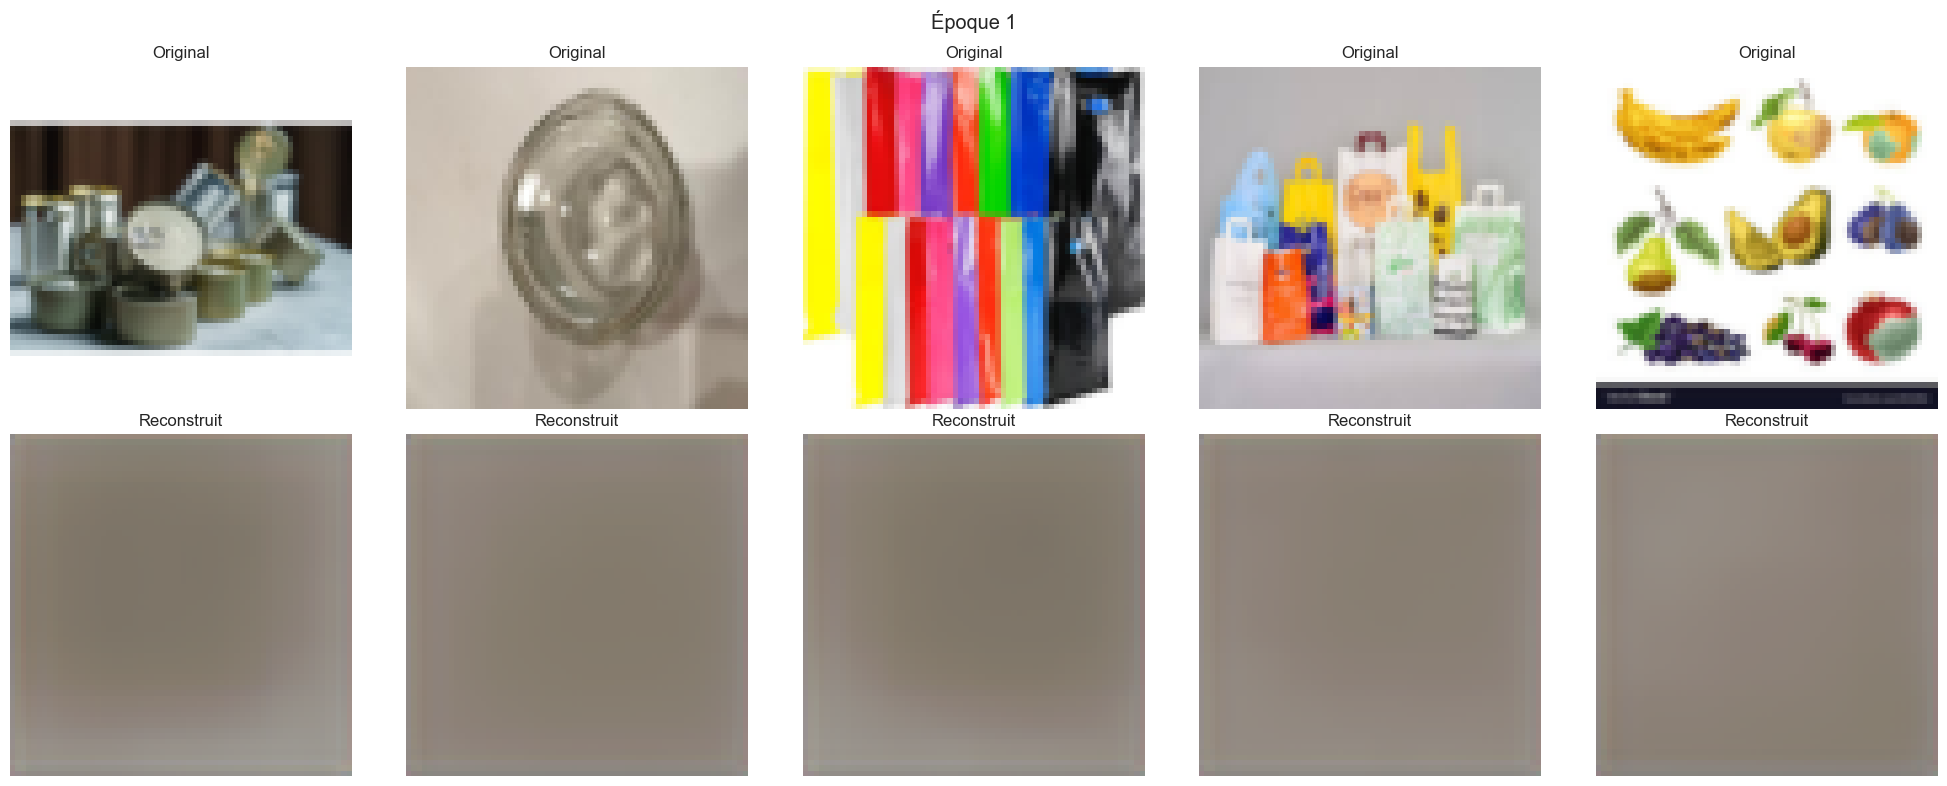

171/171 ━━━━━━━━━━━━━━━━━━━━ 745s 4s/step - kl_loss: 2076931.8750 - loss: 586.4634 - recon_loss: 544.4816 - val_kl_loss: 113.3935 - val_loss: 1055.9247 - val_recon_loss: 1055.7307 - learning_rate: 0.0010
Epoch 2/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - kl_loss: 255.5514 - loss: 391.8741 - recon_loss: 391.3238
Epoch 2: val_recon_loss improved from 1055.73071 to 709.06036, saving model to model_dct_8.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


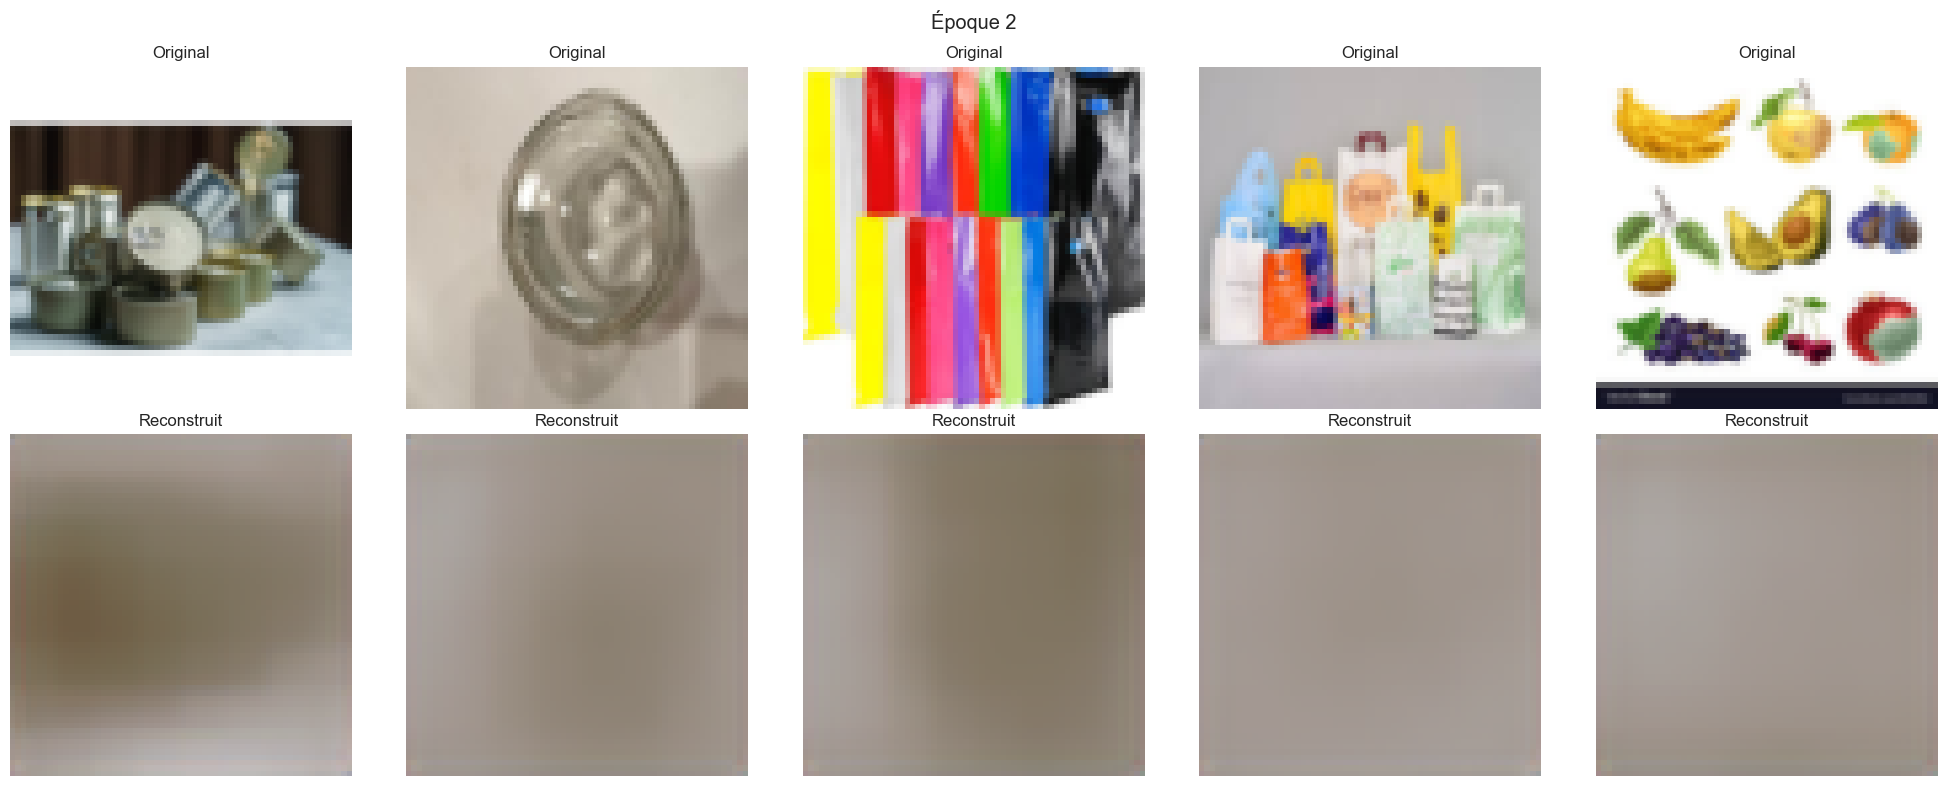

171/171 ━━━━━━━━━━━━━━━━━━━━ 691s 4s/step - kl_loss: 267.6998 - loss: 380.9806 - recon_loss: 380.2892 - val_kl_loss: 186.7119 - val_loss: 709.6988 - val_recon_loss: 709.0604 - learning_rate: 0.0010
Epoch 3/100
 94/171 ━━━━━━━━━━━━━━━━━━━━ 4:41 4s/step - kl_loss: 279.2110 - loss: 367.6848 - recon_loss: 366.6653

KeyboardInterrupt: 

In [21]:
# Compiler et entraîner le modèle avec visualisation
import time
start_time = time.time()
history = autoencoder.train(
    x_train = train_generator,
    x_val = test_generator, 
    batch_size=16,
    epochs=100,
    x_vis=X_vis,
    #epochs = start_epoch + 50,
    initial_epoch=start_epoch,
    save_path="model_dct_8.keras"
)
end_time = time.time()
#days, rem = divmod(elapsed, 86400)          
#hours, rem = divmod(rem, 3600)
#minutes, seconds = divmod(rem, 60)

#print(f"Temps d'entraînement : {int(days)}j {int(hours):02d}h {int(minutes):02d}m {int(seconds):02d}s")

autoencoder.save("model_dct_8.keras")
plot_result(history,name_fig="outo-loss",register=True)

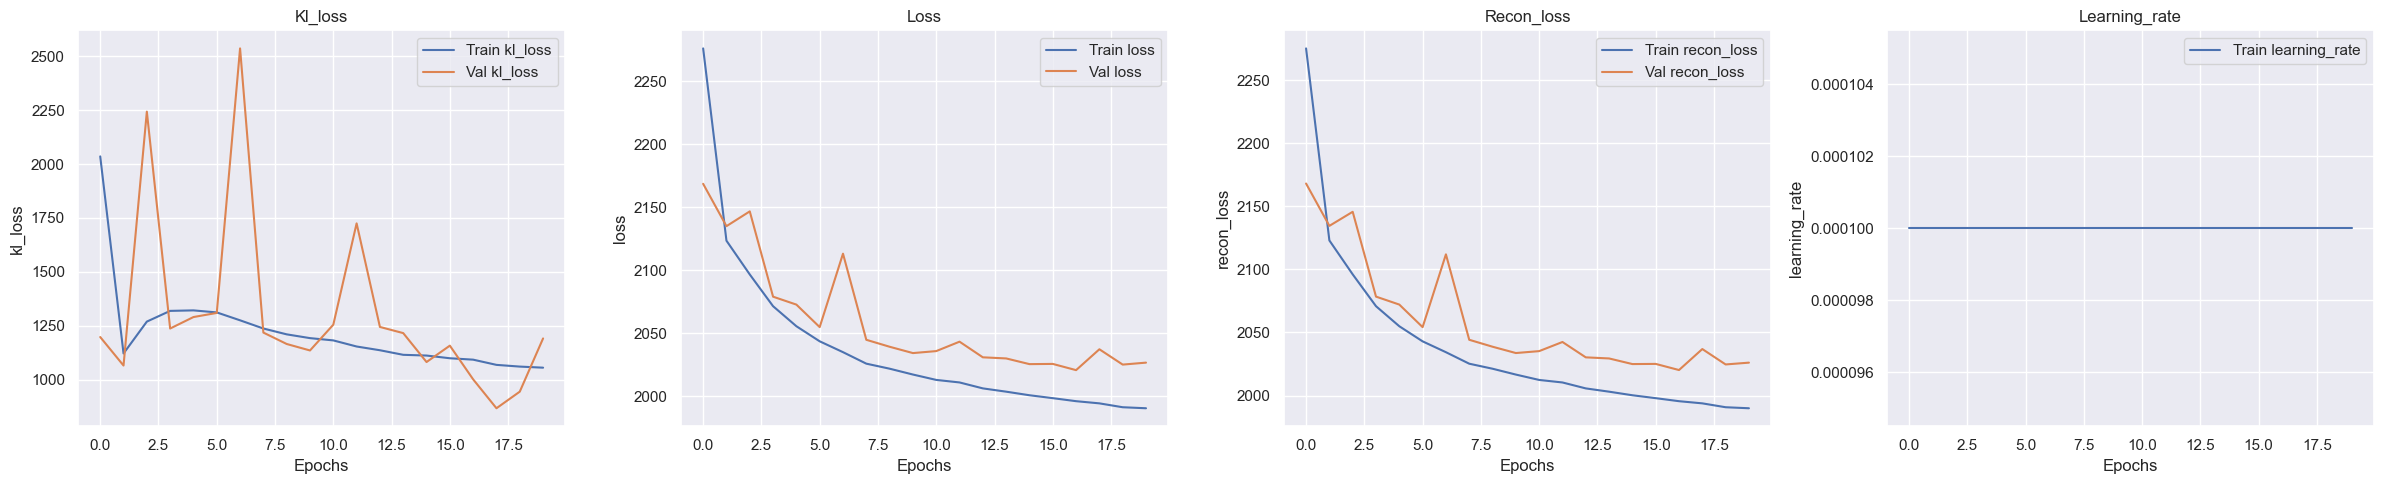

In [30]:
plot_result(history,name_fig="outo-loss",register=True)

In [ ]:
model1 = load_model("model_dct_6.keras", custom_objects={"ResidualVAE": ResidualVAE, "Sampling": Sampling})

In [ ]:
path = "C:/Users/hp/Pictures/Saved Pictures/im1.jpg"

In [ ]:
tf.keras.utils.plot_model(model1, show_shapes=True, show_layer_names=False, dpi=120)

In [ ]:
img,_ = outils.prepare_image(img_path=path,target_size=240)

In [54]:
img = X_train[1:20]

In [55]:
encoded_imgs,g,z = autoencoder.encoder(img)

In [56]:
pred = autoencoder.decoder(z)

In [ ]:
autoencoder.save('model_dct_1.keras')

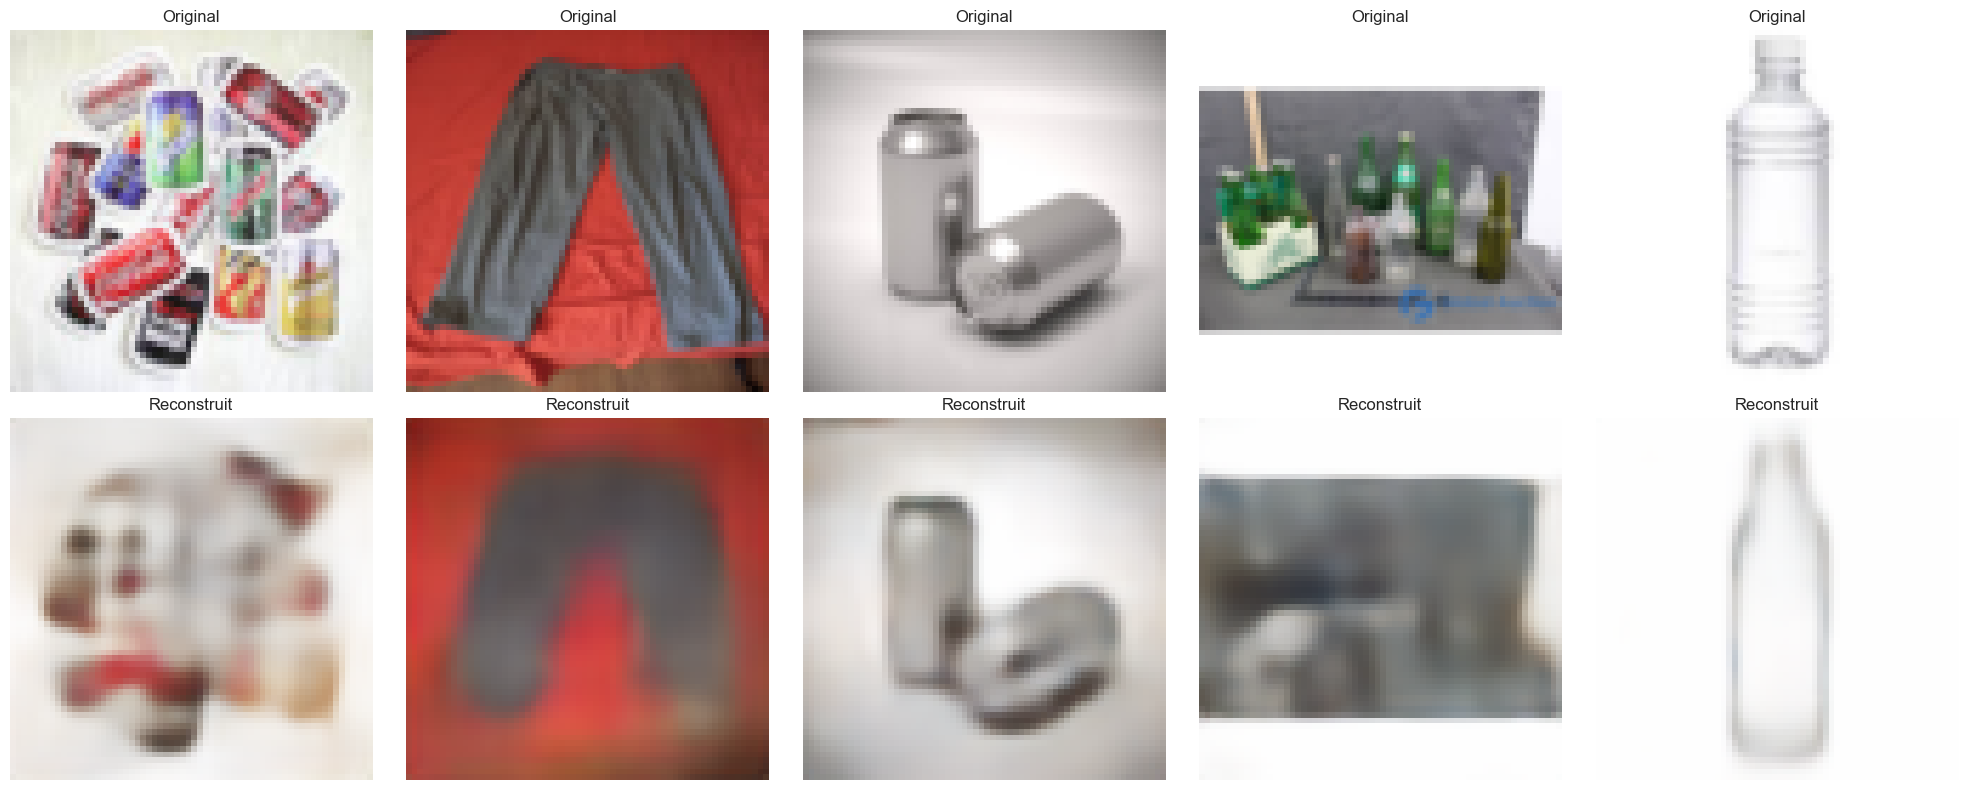

In [57]:
n = 5
plt.figure(figsize=(20, 8))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(np.clip(img[i], 0, 1))
    plt.axis("off")
    plt.title("Original")

    plt.subplot(2, n, n + i + 1)
    plt.imshow(np.clip(pred[i], 0, 1))
    plt.axis("off")
    plt.title("Reconstruit")
plt.savefig("test_auto.png")
plt.tight_layout()
plt.show()


In [22]:
df_anomalie = outils.Load_data.load_object("detect_anomalie.zip")

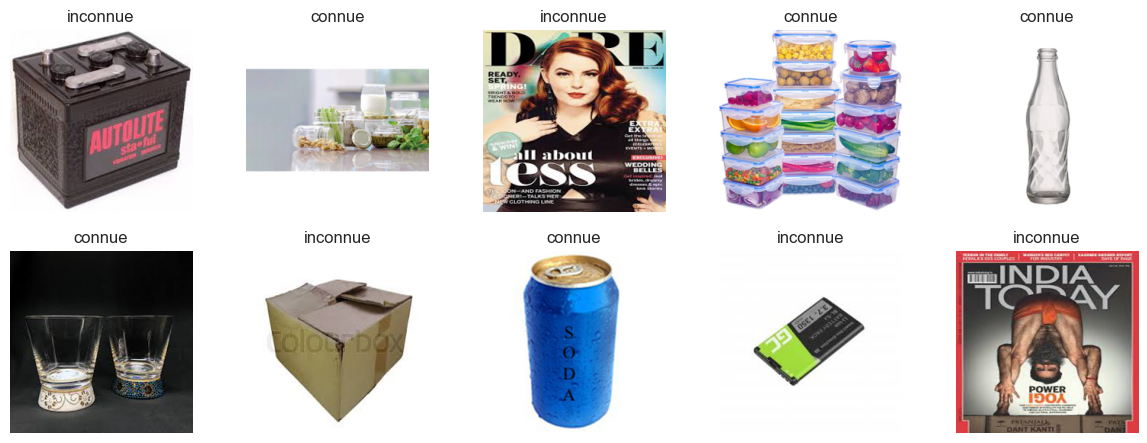

In [23]:
df_anomalie.plot(view_code=True)

In [24]:
df_anomalie.encodage()

In [29]:
df_anomalie.reshape(target_shape=(64,64,3), batch_size = 32)

Reshape en batch: 100%|██████████████████████████████████████████████████████████████| 125/125 [00:05<00:00, 21.43it/s]


In [30]:
(X_test_an, y_test_an), (_,_) = df_anomalie.create_data(test_size=0.0000000000001)

In [26]:
np.unique(y_test_an,return_counts=True)

(array([0, 1], dtype=int32), array([1999, 2000]))

In [48]:
(X_test_an, y_test_an), (_,_) = df_anomalie.create_data(test_size=0.0000000000001)

In [49]:
X_test_an = X_test_an.astype('float32') / 255.

In [45]:
encoded_imgs,g,z = model1.encoder(np.expand_dims(X_test_an[9]/255, axis = 0))
recon = model1.decoder(z)

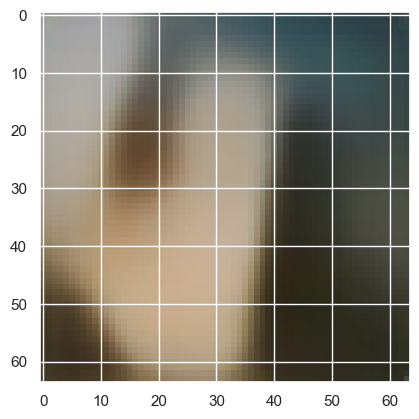

In [46]:
plt.imshow(recon[0])

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import (
    confusion_matrix, roc_curve,
    precision_recall_curve, classification_report, roc_auc_score
)
import seaborn as sns
import pandas as pd

def detect_anomalies_complete_v2(autoencoder, x_data, y_true, thresholds, batch_size=32):
    """
    Détection d'anomalies complète avec visualisations et rapport détaillé.
    - Calcule les erreurs de reconstruction de manière itérative (optimisée pour faible RAM)
    - Évalue les performances selon plusieurs seuils
    - Trace les courbes des métriques + du nombre d’anomalies détectées
    - Affiche la matrice de confusion (en %) avec labels 'Normal' et 'Anormal'
    - Affiche un rapport global de classification
    """

    # ---------------------------
    # Étape 1 : Calcul des erreurs
    # ---------------------------
    print("Calcul des erreurs de reconstruction...")
    n = len(x_data)
    errors = []
    for i in tqdm(range(0, n, batch_size)):
        batch = x_data[i:i + batch_size]
        encoded_imgs,g,z = autoencoder.encoder(batch)
        recon = autoencoder.decoder(z)
        batch_errors = np.mean(np.square(batch - recon), axis=(1, 2, 3))
        errors.extend(batch_errors)
    errors = np.array(errors)

    # ---------------------------
    # Étape 2 : Histogramme des erreurs
    # ---------------------------
    plt.figure(figsize=(8, 5))
    plt.hist(errors[y_true == 0], bins=40, alpha=0.7, label="Normales")
    plt.hist(errors[y_true == 1], bins=40, alpha=0.7, label="Anomalies")
    plt.xlabel("Erreur de reconstruction")
    plt.ylabel("Fréquence")
    plt.title("Distribution des erreurs de reconstruction")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---------------------------
    # Étape 3 : Calcul des métriques pour chaque seuil
    # ---------------------------
    results = {}
    n_normals_detected, n_anomalies_detected = [], []

    for t in thresholds:
        y_pred = (errors > t).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)
        prec = tp / (tp + fp + 1e-8)
        rec = tp / (tp + fn + 1e-8)
        f1 = 2 * prec * rec / (prec + rec + 1e-8)
        results[t] = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

        n_normals_detected.append((y_pred == 0).sum())
        n_anomalies_detected.append((y_pred == 1).sum())

    # Convertir en DataFrame pour analyse
    df_metrics = pd.DataFrame(results).T
    df_metrics["anomalies_detected"] = n_anomalies_detected
    df_metrics["normals_detected"] = n_normals_detected

    # ---------------------------
    # Étape 4 : Tracer les métriques et détections
    # ---------------------------
    fig, axes = plt.subplots(1, 2, figsize=(16,6))

    # (a) Nombre de détections
    axes[0].plot(thresholds, df_metrics["normals_detected"], label="Normales détectées")
    axes[0].plot(thresholds, df_metrics["anomalies_detected"], label="Anomalies détectées")
    axes[0].set_title("Évolution du nombre de détections")
    axes[0].set_xlabel("Seuil d'anomalie")
    axes[0].set_ylabel("Nombre d'échantillons")
    axes[0].legend()
    axes[0].grid(True)
    
    # (b) Évolution des métriques
    axes[1].plot(thresholds, df_metrics["accuracy"], label="Exactitude")
    axes[1].plot(thresholds, df_metrics["precision"], label="Précision")
    axes[1].plot(thresholds, df_metrics["recall"], label="Rappel")
    axes[1].plot(thresholds, df_metrics["f1"], label="F1-score")
    axes[1].set_title("Évolution des métriques selon le seuil")
    axes[1].set_xlabel("Seuil d'anomalie")
    axes[1].set_ylabel("Valeur métrique")
    axes[1].legend()
    axes[1].grid(True)

    plt.savefig("auto_metrix.png")
    plt.tight_layout()
    plt.show()

    # ---------------------------
    # Étape 5 : Courbes ROC et PR
    # ---------------------------
    fpr, tpr, _ = roc_curve(y_true, errors)
    precision, recall, _ = precision_recall_curve(y_true, errors)
    auc_score = roc_auc_score(y_true, errors)

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
    plt.xlabel("Taux de faux positifs (FPR)")
    plt.ylabel("Taux de vrais positifs (TPR)")
    plt.title("Courbe ROC")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision)
    plt.xlabel("Rappel")
    plt.ylabel("Précision")
    plt.title("Courbe Précision-Rappel")
    plt.grid(True)
    plt.show()

    # ---------------------------
    # Étape 6 : Seuil optimal + rapport complet
    # ---------------------------
    best_t = df_metrics["f1"].idxmax()
    print(f"\n Seuil optimal (F1 max) = {best_t:.5f}\n")
    print("Métriques associées :")
    print(df_metrics.loc[best_t].to_string(), "\n")

    y_pred_best = (errors > best_t).astype(int)

    # Matrice de confusion (avec labels et pourcentages)
    cm_best = confusion_matrix(y_true, y_pred_best)
    cm_percent = cm_best.astype('float') / cm_best.sum(axis=1)[:, np.newaxis]

    labels = ["Normal", "Anormal"]
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap="Blues", cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Prédiction")
    plt.ylabel("Vérité terrain")
    plt.title("Matrice de confusion - Seuil optimal")
    plt.savefig("matrix_auto.png")
    plt.show()

    print("Rapport de classification :")
    print(classification_report(y_true, y_pred_best, target_names=labels, digits=3))

    return errors, df_metrics, best_t


Calcul des erreurs de reconstruction...


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [01:43<00:00,  2.41it/s]


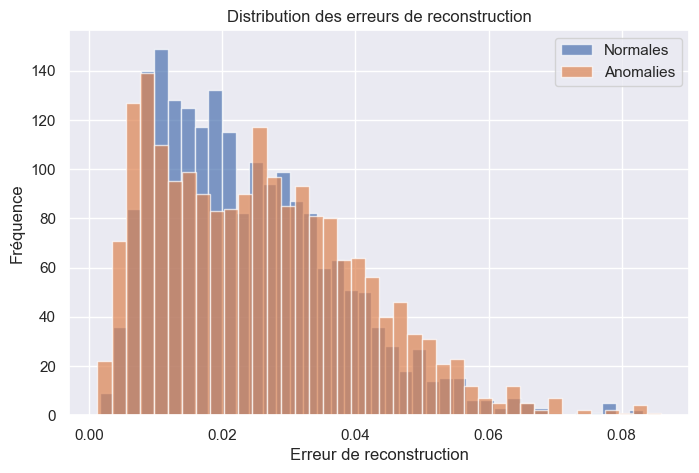

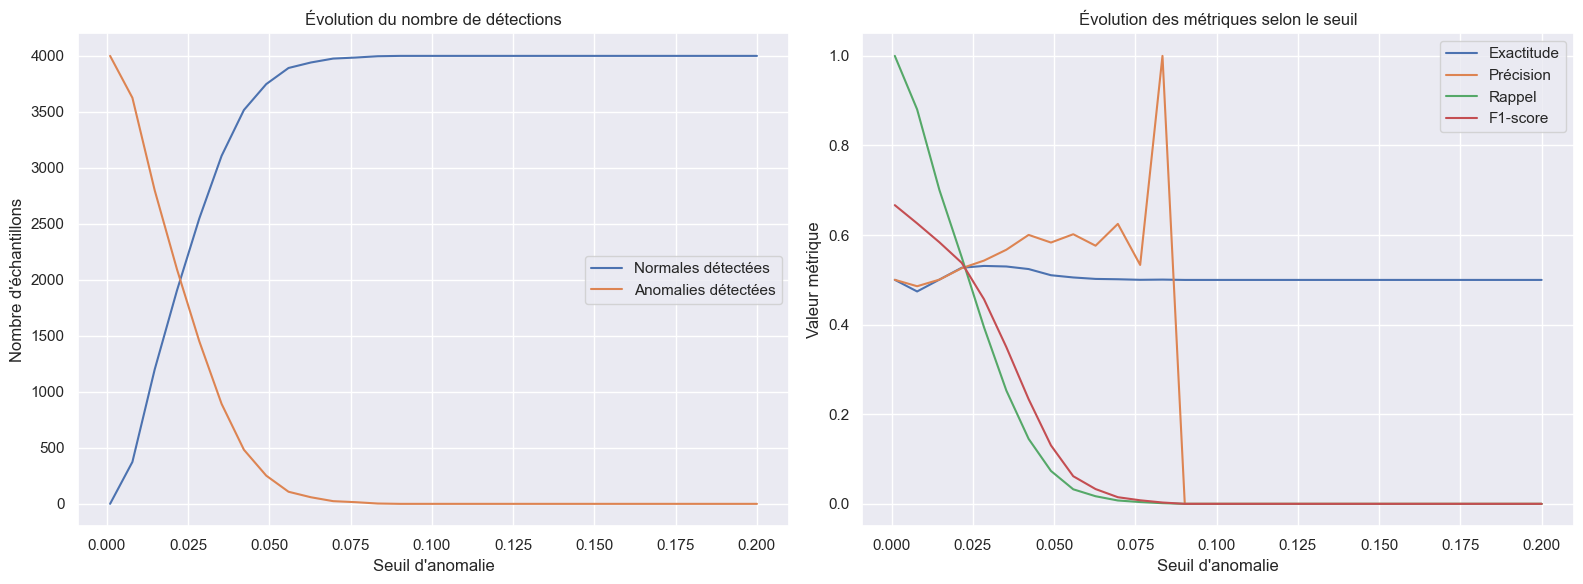

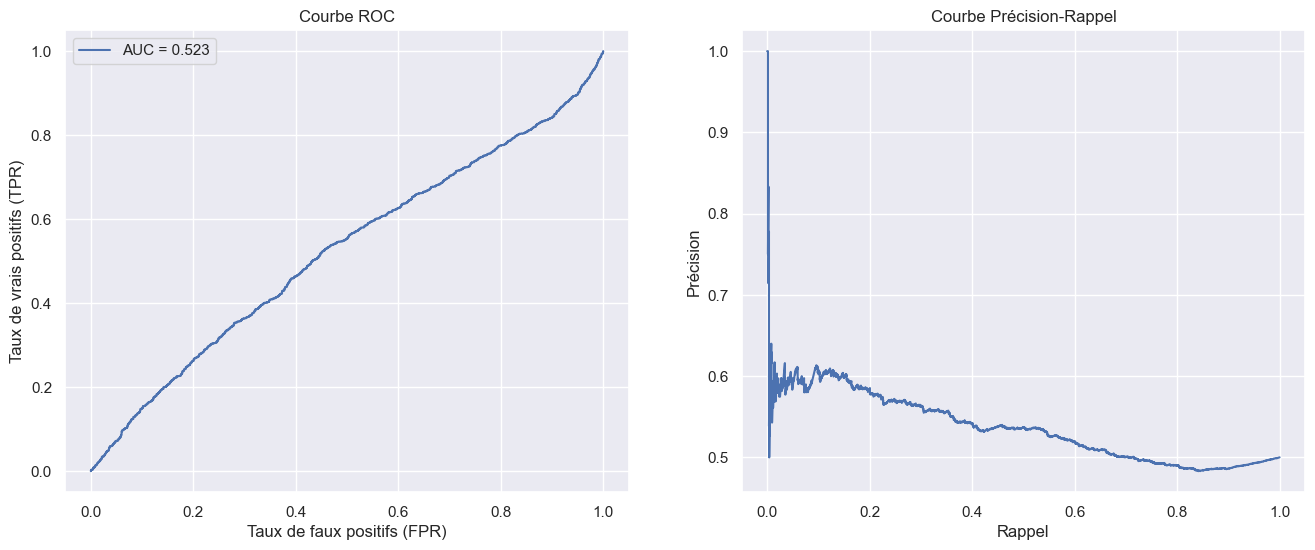


 Seuil optimal (F1 max) = 0.00100

Métriques associées :
accuracy                 0.500125
precision                0.500125
recall                   1.000000
f1                       0.666778
anomalies_detected    3999.000000
normals_detected         0.000000 



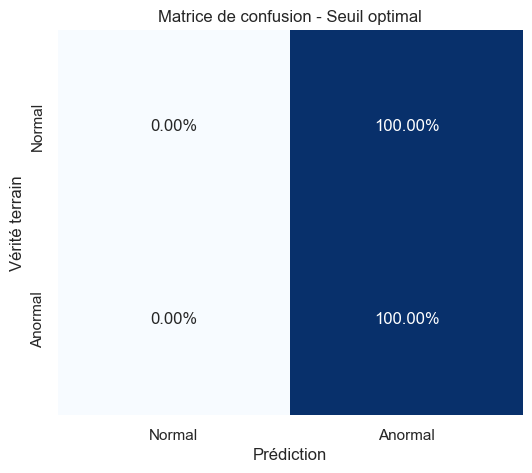

Rapport de classification :
              precision    recall  f1-score   support

      Normal      0.000     0.000     0.000      1999
     Anormal      0.500     1.000     0.667      2000

    accuracy                          0.500      3999
   macro avg      0.250     0.500     0.333      3999
weighted avg      0.250     0.500     0.333      3999



C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [51]:
thresholds = np.linspace(0.001, 0.2, 30)
errors, df_metrics, best_t = detect_anomalies_complete_v2(model1, X_test_an, y_test_an, thresholds, batch_size=16)

In [26]:
z_mean, z_logvar, z = autoencoder.encoder.predict(np.expand_dims(X_train[9], axis = 0))
recon = autoencoder.decoder.predict(z)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


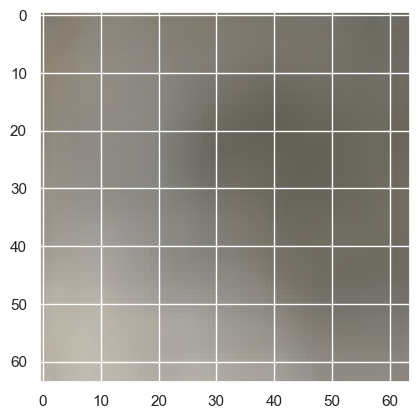

In [27]:
plt.imshow(recon[0])